Biblioteka "pandas" umożliwa w łatwy sposób wyodrębnianie, przetwarzanie oraz ładowanie danych w formie tabel.
<br>"Numpy" umożliwia operacje na macierzach.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
%matplotlib inline

Najpierw załadowano dane z przygotowanego wcześniej pliku:

In [2]:
df = pd.read_csv("final.csv")

In [3]:
df

,GS,S,ST,C,F,Y,R,P,V,Rezultat
0,-1.400000,0.200000,0.800000,1.200000,2.200000,1.000000,0.200000,-1.600000,-192.30,H
1,0.200000,2.400000,1.600000,-1.400000,-1.400000,-1.000000,0.200000,1.600000,-34.70,H
2,0.200000,4.200000,3.600000,0.400000,0.400000,-0.800000,0.000000,-0.400000,-58.28,A
3,0.400000,5.400000,2.200000,4.600000,-3.800000,-0.200000,0.000000,-0.400000,-14.40,A
4,2.200000,4.600000,2.600000,1.200000,-5.000000,-1.000000,-0.400000,2.200000,281.48,H
...,...,...,...,...,...,...,...,...,...,...
4645,-0.013805,2.239528,0.474690,0.875870,2.188909,0.170973,-0.004602,0.221475,89.58,H
4646,-0.499308,-1.485124,-1.889293,-0.638730,-0.224961,-0.177910,-0.105691,-0.193652,-407.55,A
4647,-0.401450,-2.026038,-2.434410,-0.831466,-0.272358,-0.120083,-0.004285,-0.127115,-877.35,A
4648,0.468326,2.415215,1.804581,1.154299,-0.607805,-0.477206,-0.058145,0.677885,39.50,A


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4650 entries, 0 to 4649
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   GS        4650 non-null   float64
 1   S         4650 non-null   float64
 2   ST        4650 non-null   float64
 3   C         4650 non-null   float64
 4   F         4650 non-null   float64
 5   Y         4650 non-null   float64
 6   R         4650 non-null   float64
 7   P         4650 non-null   float64
 8   V         4650 non-null   float64
 9   Rezultat  4650 non-null   object 
dtypes: float64(9), object(1)
memory usage: 363.4+ KB


Za pomocą funkcji "df.info()" można zauważyć, że tabela posiada kolumny liczbowe oraz jedną z danymi kategoryzującymi.

W następnym kroku należy przetworzyć etykiety klas w liczby całkowite, aby mogły zostać użyte podczas obliczeń.

In [5]:
from sklearn.preprocessing import LabelEncoder

X = df.iloc[:,:9].values
y = df.iloc[:,9].values
le = LabelEncoder()
y = le.fit_transform(y)
print("Klasy: ",le.classes_)

Klasy:  ['A' 'D' 'H']


W dalszej kolejności rozdzielono dane na 70% próbek uczących i 30% próbek testowych.
<br>Za pomocą funkcji "stratify" przemieszano kolejność próbek, aby w zbiorze danych testowych oraz uczących była taka sama proporcja pierwotnych klas.

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
train_test_split(X,y, test_size=0.3, stratify=y, random_state=1)

Za pomocą algorytmu losowego lasu można uzyskać ważność cechy jako uśredniony spadek zanieczyszczeń (im mniejsze zanieczyszczenie tym lepiej została rozdzielona dana klasa)
<br> Uśredniony spadek zanieczyszczeń został obliczony na podstawie średniej redukcji zanieczyszczeń w pięciuset drzewach decyzyjnych.

 1) V               0.139208
 2) P               0.121752
 3) C               0.112147
 4) S               0.110300
 5) ST              0.108717
 6) GS              0.108393
 7) Y               0.101682
 8) F               0.100188
 9) R               0.097613


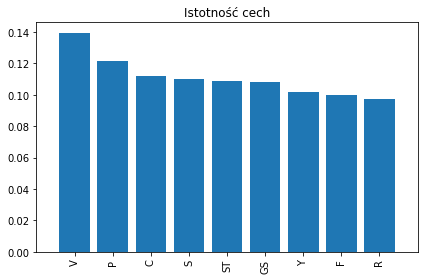

In [7]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = df.columns[:18]

forest = RandomForestClassifier(n_estimators=500, random_state=1)

forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 15,
                            feat_labels[indices[f]],
                            importances[indices[f]]))
    
plt.title("Istotność cech")
plt.bar(range(X_train.shape[1]),
       importances[indices],
       align='center')
plt.xticks(range(X_train.shape[1]),
          feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

Dzięki prostej implementacji można poglądowo ocenić, że różnica w wartości drużyny w danym meczu jest najbardziej rozróżnialną cechą. Najmniej rozróżnialną cechą jest różnica w czerwonych kartkach pomiędzy drużynami. 

Aby użyć klasyfikatora liniowego (w tym przypadku regresja logistyczna) należy przeskalować cechy. W tym celu przeprowadzono standaryzację zmiennych i wstępną prognozę:

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(StandardScaler(),
                       LogisticRegression(random_state=1))
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print('Dokładność testu %.3f' % (pipe_lr.score(X_test, y_test)))

Dokładność testu 0.556


Następnie użyto k-krotnego sprawdzianu krzyżowego. Polega on na rozdzieleniu zestawu danych na k niezastępowanych podzbiorów, gdzie k-1 podzbiorów zostaje użyte do uczenia modelu, a jeden do pomiaru skuteczności. Operacja wykonywana jest k-krotnie, więc finalnie otrzymuje się k modeli i pomiarów skuteczności.

In [9]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator=pipe_lr,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs = -1)
print('Wyniki dokładności sprawdzianu: %s' % scores)
print('\nDokładność sprawdzianu: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Wyniki dokładności sprawdzianu: [0.56748466 0.54294479 0.55521472 0.52147239 0.54601227 0.52615385
 0.53846154 0.50153846 0.52923077 0.56923077]

Dokładność sprawdzianu: 0.540 +/- 0.020


### Diagnoza algorytmu poprzez krzywe uczenia oraz krzywe walidacji

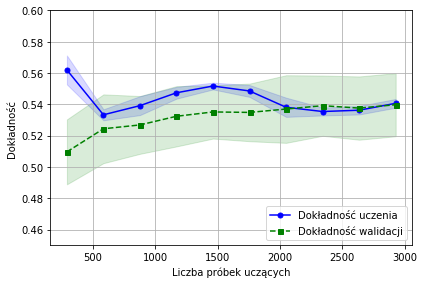

In [10]:
from sklearn.model_selection import learning_curve
pipe_lr = make_pipeline(StandardScaler(),
                       LogisticRegression(penalty='l2', random_state=1))
train_sizes, train_scores, test_scores =\
            learning_curve(estimator=pipe_lr,
                          X=X_train,
                          y=y_train,
                          train_sizes = np.linspace(0.1, 1.0, 10),
                          cv=10,
                          n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Dokładność uczenia')
plt.fill_between(train_sizes,
                train_mean + train_std,
                train_mean - train_std,
                alpha = 0.15, color='blue')
plt.plot(train_sizes, test_mean,
        color='green', linestyle = '--', marker='s', markersize=5,
        label='Dokładność walidacji')
plt.fill_between(train_sizes,
                test_mean + test_std,
                test_mean - test_std,
                alpha=0.15, color='green')
plt.grid()
plt.xlabel('Liczba próbek uczących')
plt.ylabel('Dokładność')
plt.legend(loc='lower right')
plt.tight_layout()
plt.ylim([0.45, 0.6])
plt.show()

Wykres przedstawia krzywą uczenia modelu. Wykonano dziesięć równomierne rozłożonych zestawów uczących, za pomocą k-krotnego sprawdzianu krzyżowego. Niebieska linia oznacza dokładność uczenia, a zielona dokładność walidacji. Wypełnienie w kolorach danej linii oznacza odchylenie standardowe średnich wartości. <br>Można zauważyć że model posiada duże obciążenie, czyli charakteryzuje go niska dokładność uczenia i walidacji. Niestety, model nie dopasował się odpowiednio do danych uczących przy prawie 3000 próbkach uczących.

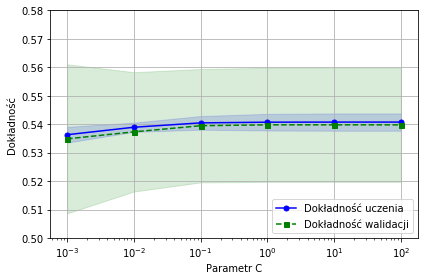

In [11]:
from sklearn.model_selection import validation_curve
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores,  test_scores = validation_curve(estimator = pipe_lr,
                                             X=X_train,
                                             y=y_train,
                                             param_name='logisticregression__C',
                                             param_range=param_range,
                                             cv=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='Dokładność uczenia')
plt.fill_between(param_range, train_mean + train_std,
               train_mean - train_std, alpha = 0.15, color='blue')
plt.plot(param_range, test_mean, color='green', linestyle='--',
        marker='s', markersize=5,
        label = 'Dokładność walidacji')
plt.fill_between(param_range,
                test_mean + test_std,
                test_mean - test_std,
                alpha = 0.15, color='green')
plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parametr C')
plt.ylabel('Dokładność')
plt.ylim([0.5,0.58])
plt.tight_layout()
plt.show()

* Im większy parametr C, tym bardziej model 'kara' za błędy podczas uczenia *

Do powyższych obliczeń zdefiniowano przedział wartości z odwrotnością parametru regularyzacji C, aby sprawdzić dla jakiej wartości parametru model wykazuje najwyższą dokładność. Okazuje się, że różnica jest mocno znikoma, a od C=0.1 do C=100 model nie wykazuje znaczących zmian w dokładności.

### Dostrajanie modeli uczenia maszynowego za pomocą metody przeszukiwania siatki

Metoda przeszukiwania siatki działa w bardzo prosty sposób. Użytkownik wprowadza listę paramtrów modelu dla których zamierza znaleźć najwyższą dokładność modelu, a algorytm przeszukuje wszystkie możliwe opcje. Mimo prostoty, ten sposób potrzebuje dużych zasobów mocy komputera.

In [12]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

scorer = sklearn.metrics.make_scorer(sklearn.metrics.accuracy_score)

pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state=1))

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_grid = [{'svc__C': param_range, 
               'svc__kernel': ['linear']},
              {'svc__C': param_range, 
               'svc__gamma': param_range, 
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring=scorer, 
                  refit=True,
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.5360896649362907
{'svc__C': 1.0, 'svc__kernel': 'linear'}


Test przeprowadzono za pomocą maszyny wektorów nośnych (SVM). Najwyższe dopasowanie modelu otrzymano przy parametrach: C:1, jądro modelu: liniowe.

In [13]:
clf = gs.best_estimator_

print('Dokładność walidacji: %.3f' % clf.score(X_test, y_test))

Dokładność walidacji: 0.558


Po oszacowaniu skuteczności poprzez użycie niezależnej bazy danych otrzymano dokładność walidacji na poziomie 0.558.

### Zagnieżdzony sprawdziań krzyżowy - selekcja algorytmu

Zastosowano kroswalidację 5x2.

In [14]:
from sklearn.model_selection import cross_validate
gs = GridSearchCV(estimator=pipe_svc,
                 param_grid=param_grid,
                 scoring=scorer,
                 cv=2)
scores = cross_validate(gs, X_train, y_train, scoring=scorer, cv=5)
print("Dokładność sprawdzianu krzyżowego: %.3f +/- %.3f" % (np.mean(scores['test_score'])
                                                            , np.std(scores['test_score'])))

Dokładność sprawdzianu krzyżowego: 0.533 +/- 0.009


In [15]:
from sklearn.tree import DecisionTreeClassifier

gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=1),
                 param_grid=[{'max_depth': [1,2,3,4,5,6,7,None]}],
                 scoring=scorer, cv=2)

scores = cross_val_score(gs,
                        X_train,
                        y_train,
                        scoring=scorer,
                        cv=5)
print("Dokładność sprawdzianu krzyżowego: %.3f +/- %.3f" % (np.mean(scores), np.std(scores)))

Dokładność sprawdzianu krzyżowego: 0.527 +/- 0.012


Na podstawie dwóch powyższych sprawdzianów stwierdzono, że minimalnie lepiej sprawdza się algorytm maszyn wektorów nośnych.

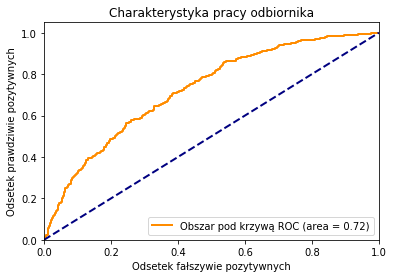

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

y1 = label_binarize(y, classes=[0, 1, 2])
n_classes = y1.shape[1]
n_samples, n_features = X.shape

X_train1, X_test1, y_train1, y_test1 = \
train_test_split(X,y1, test_size=0.3, stratify=y, random_state=1)

classifier = OneVsRestClassifier(make_pipeline(StandardScaler(),
                        LogisticRegression(penalty='l2', 
                                           random_state=1,
                                           solver='lbfgs',
                                           C=100.0)))

y_score = classifier.fit(X_train1, y_train1).decision_function(X_test1)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test1[:,i], y_score[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test1.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='Obszar pod krzywą ROC (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Odsetek fałszywie pozytywnych')
plt.ylabel('Odsetek prawdziwie pozytywnych')
plt.title('Charakterystyka pracy odbiornika')
plt.legend(loc="lower right")
plt.show()

Powyższy wykres przedstawia charakterystykę pracy odbiornika. Obszar pod krzywą ROC wynosi 0.72.

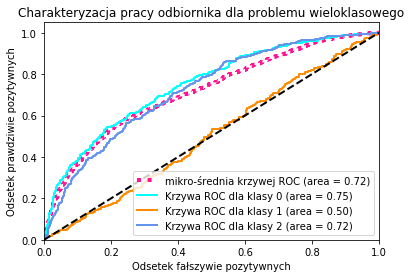

In [17]:
from sklearn.metrics import roc_curve, auc
from distutils.version import LooseVersion as Version
from numpy import interp
from sklearn.model_selection import StratifiedKFold

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='mikro-średnia krzywej ROC (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

# plt.plot(fpr["macro"], tpr["macro"],
#          label='makro-średnia krzywej ROC (area = {0:0.2f})'
#                ''.format(roc_auc["macro"]),
#          color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='Krzywa ROC dla klasy {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Odsetek fałszywie pozytywnych')
plt.ylabel('Odsetek prawdziwie pozytywnych')
plt.title('Charakteryzacja pracy odbiornika dla problemu wieloklasowego')
plt.legend(loc="lower right")
plt.show()

Powyższy wykres to rozszerzona wersja wykresu z krzywą ROC. W celu lepszej interpretacji wyników w modelu wieloklasowym, podzielono obszary pod krzywą ROC na każdą etykietę. Z racji problemu wieloklasowe, użyto metryki "ROC - jeden przeciw reszcie". Dodano również krzywą z uśrednionym (mikro) wynikiem dla wszystkich trzech etykiet. Klasa 0 i 2 to wygrana gospodarza oraz gościa. Obszar pod krzywą ROC dla tych klas wynosi odpowiednio 0.74 i 0.72. Nie jest to zadowalający wynik, a na dodatek krzywa etykiety 1 (remis) zwraca bardzo podobną metrykę skuteczności co losowe zgadywanie. Dzięki temu wykresowi można założyć, że model całościowo posiada wysokie obciążenie, a prognozując remis jest równie skuteczny co rzut monetą.

## Zastosowanie uczenia zespołowego do ulepszenia modelu 

### Zastosowanie reguły głosowania większościowego do prognozy

W dalszej części pracy sprawdzono, w jakim każdy z klasyfikatorów (regresja logistyczna, drzewo decyzyjne oraz -najbliższych sąsiadów) radzą sobie z klasyfikacją etykiet a następnie - czy połączenie trzech klasyfikatorów w głosowanie większościowe zwiększy dokładność modelu. Metryka skuteczności ze względu na charakter modelu jako wieloklasowy, to "ROC - jeden przeciw reszcie".

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_validate

clf1 = LogisticRegression(penalty='l2',
                        C=0.001,
                        random_state=1)
clf2 = DecisionTreeClassifier(max_depth=1,
                             criterion='entropy',
                             random_state=1)
clf3 = KNeighborsClassifier(n_neighbors=1,
                           p=2,
                           metric='minkowski')
pipe1 = Pipeline([['sc', StandardScaler()],
                   ['clf',clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])

clf_labels = ['Regresja logistyczna', 'Drzewo decyzyjne', 'K-najbliższych sąsiadów']
print('Dziesięciokrotny sprawdzian krzyżowy:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_validate(estimator=clf,
                            X=X_train,
                            y=y_train,
                            cv=10,
                            scoring='roc_auc_ovr')
    print("Obszar pod krzywą ROC: %0.2f (+/- %0.2f) [%s]" %
          (scores['test_score'].mean(),scores['test_score'].std(), label))

Dziesięciokrotny sprawdzian krzyżowy:

Obszar pod krzywą ROC: 0.66 (+/- 0.03) [Regresja logistyczna]
Obszar pod krzywą ROC: 0.60 (+/- 0.02) [Drzewo decyzyjne]
Obszar pod krzywą ROC: 0.55 (+/- 0.02) [K-najbliższych sąsiadów]


Po interpretacji metryki skuteczności modelu można zauważyć, że najwyższą dokładność generuje algorytm regresji logistycznej (0.66). Drzewo decyzyjne radzi sobie gorzej (0.6) a k-najbliżsi sąsiedzi generują wynik na poziomie 0.55.

## Złączenie klasyfikatorów w celu stworzenia głosowania większościowego

In [19]:
from sklearn.ensemble import VotingClassifier
from mlxtend.classifier import EnsembleVoteClassifier

mv_clf = EnsembleVoteClassifier(clfs=[pipe1,clf2,pipe3],voting='hard')
clf_labels = ['Regresja logistyczna', 'Drzewo decyzyjne', 'K-najbliższych sąsiadów']
clf_labels += ['Głosowanie większościowe']
all_clf = [pipe1, clf2, pipe3, mv_clf]
for clf, label in zip(all_clf, clf_labels):
    scores = cross_validate(estimator=clf,
                            X=X_train,
                            y=y_train,
                            cv=10,
                            scoring='roc_auc_ovr')
    print("Obszar pod krzywą ROC: %0.2f (+/- %0.2f) [%s]" %
          (scores['test_score'].mean(),scores['test_score'].std(), label))

Obszar pod krzywą ROC: 0.66 (+/- 0.03) [Regresja logistyczna]
Obszar pod krzywą ROC: 0.60 (+/- 0.02) [Drzewo decyzyjne]
Obszar pod krzywą ROC: 0.55 (+/- 0.02) [K-najbliższych sąsiadów]
Obszar pod krzywą ROC: 0.63 (+/- 0.03) [Głosowanie większościowe]


Niestety, głosowanie większościowe nie poprawiło skuteczności predykcji.

In [20]:
from sklearn.model_selection import GridSearchCV

params = {'decisiontreeclassifier__max_depth': [1, 2],
          'pipeline-1__clf__C': [0.001, 0.1, 100.0]}

grid = GridSearchCV(estimator=mv_clf,
                    param_grid=params,
                    cv=10,
                    scoring='accuracy')
grid.fit(X_train, y_train)

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_['mean_test_score'][r], 
             grid.cv_results_['std_test_score'][r] / 2.0, 
             grid.cv_results_['params'][r]))

0.521 +/- 0.01 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.523 +/- 0.01 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.523 +/- 0.01 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.535 +/- 0.01 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.535 +/- 0.01 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.535 +/- 0.01 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


In [21]:
print('Najlepsze parametry: %s' % grid.best_params_)
print('Dokładność: %.2f' % grid.best_score_)

Najlepsze parametry: {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
Dokładność: 0.54


Wykorzystano klasyfikator głosowania większościowego, więc wyodrębniono (w celach naukowych) najlepsze parametry dla modeli w ogólnym klasyfikatorze.

### Agregacja

Aby polepszyć dokładność modelu, użyto techniki agregacji i porównano z algorytmem drzewa decyzyjnego:
<br>*Teoretycznie dokładność powinna wzrosnąć.*

In [22]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=2,
                              random_state=1)

bag = BaggingClassifier(base_estimator=tree,
                        n_estimators=500, 
                        max_samples=1.0, 
                        max_features=1.0, 
                        bootstrap=True, 
                        bootstrap_features=False, 
                        n_jobs=-1, 
                        random_state=1)

In [23]:
from sklearn.metrics import accuracy_score

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Dokładność drzewa decyzyjnego dla danych uczących/testowych %.3f/%.3f'
      % (tree_train, tree_test))

bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred) 
bag_test = accuracy_score(y_test, y_test_pred) 
print('Dokładność agregacji dla danych uczących/testowych %.3f/%.3f'
      % (bag_train, bag_test))

Dokładność drzewa decyzyjnego dla danych uczących/testowych 0.531/0.551
Dokładność agregacji dla danych uczących/testowych 0.540/0.559


In [24]:
from sklearn.ensemble import AdaBoostClassifier

tree =  DecisionTreeClassifier(criterion='entropy', 
                              max_depth=2,
                              random_state=1)

ada = AdaBoostClassifier(base_estimator=tree,
                         n_estimators=500, 
                         learning_rate=0.1,
                         random_state=1)

In [25]:
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Dokładność drzewa decyzyjnego dla danych uczących/testowych %.3f/%.3f'
      % (tree_train, tree_test))

ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred) 
ada_test = accuracy_score(y_test, y_test_pred) 
print('Dokładność algorytmu AdaBoost dla danych uczących/testowych %.3f/%.3f'
      % (ada_train, ada_test))

Dokładność drzewa decyzyjnego dla danych uczących/testowych 0.531/0.551
Dokładność algorytmu AdaBoost dla danych uczących/testowych 0.677/0.522


Niestety, agregacja nie podwyższyła znacznie dokładności modelu, a zastosowany po niej algorytm AdaBoost (który teoretycznie powinien jeszcze bardziej poprawić dokładność modelu) bardziej pogorszył wynik. Można zauważyć, że AdaBoost znacznie zwiększył dokładność zestawu uczącego przy obniżeniu dokładności klasyfikacji z zestawu testowego. Oznacza to, że model jest mocno obciążony i algorytm uległ przetrenowaniu.